Case Study of Ground Ball Pitchers vs Fly Ball Pitchers

Data Collection of MLB Pitchers, collect and preprocess data from the last 5 years.


In [83]:
import os 
import sys
import sklearn 
import numpy as np
import pandas as pd
from pybaseball import pitching_stats
from pybaseball import cache
cache.enable()

In [84]:
START_YEAR = 2024
END_YEAR = 2024


pitching = pitching_stats(start_season=START_YEAR, end_season=END_YEAR)

# filter selected columns like idfg, season, player_name, era, .....
pitching = pitching[['IDfg', 'Season', 'Name', 'ERA', 
                     'FIP', 'xFIP', 'xERA', 'GB%', 'FB%',  
                     'K%', 'BB%', 'HR/FB', 'HardHit%', 'BABIP', 'FB% 2','SL%', 
                    ]]

# preprocess nan columns 
pitching = pitching.fillna(0)

pitching.to_csv(f'pitching_stats_{START_YEAR} - {END_YEAR}.csv', index=False)




Using Unsupervised Learning to cluster pitchers into ground ball and fly ball categories. Plotting ground ball rates against fly ball rates to verify negative correlation.

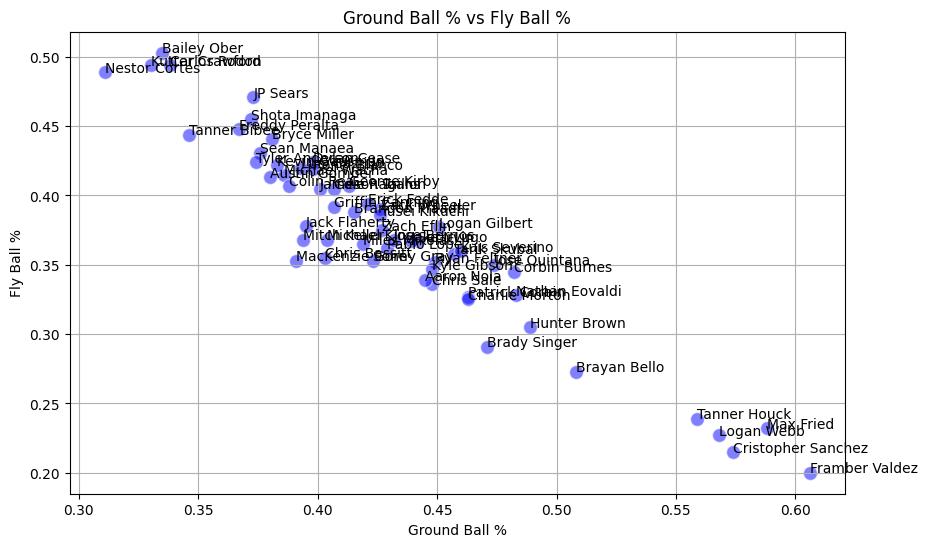

In [106]:
import matplotlib.pyplot as plt

names = [name for name in pitching['Name']]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)


for i, txt in enumerate(names):
    
    ax.annotate(txt, 
                (pitching.iloc[i]['GB%'], 
                pitching.iloc[i]['FB%']))

plt.scatter(pitching['GB%'], pitching['FB%'], alpha=0.5, c='blue', edgecolors='w', s=100)
plt.title('Ground Ball % vs Fly Ball %')
plt.xlabel('Ground Ball %')
plt.ylabel('Fly Ball %')
plt.grid(True)
plt.savefig(f'GB_vs_FB_{START_YEAR}_{END_YEAR}.png')
plt.show()





Using clustering models such as K-Means, Gaussian Mixture Models, and DBSCAN to identify clusters of ground ball and fly ball pitchers.


In [86]:
from sklearn.decomposition import PCA

# Select numerical columns for PCA
numerical_cols = ['ERA', 'FIP', 'xFIP', 'xERA', 'GB%', 'FB%', 
                  'K%', 'BB%', 'HR/FB', 'HardHit%', 'BABIP', 'FB% 2', 'SL%']
pitching_numerical = pitching[numerical_cols]


# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pitching_scaled = scaler.fit_transform(pitching_numerical)


# picking 2 principal components that explain most of the variance
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pitching_scaled)


# Create a DataFrame with PCA results
# Get the loadings (contributions of original features to each principal component)
loadings = pd.DataFrame(pca.components_.T,
                        index=numerical_cols,
                        columns=['PC1', 'PC2'])


# Create a DataFrame for PCA results
print("contributors to PCA components:")
print("pc1 contributors:")
print(loadings['PC1'].sort_values(key=abs, ascending=False))

print("pc2 contributors:")
print(loadings['PC2'].sort_values(key=abs, ascending=False))

contributors to PCA components:
pc1 contributors:
FIP         0.448783
xERA        0.429825
xFIP        0.411343
ERA         0.394534
K%         -0.368309
HardHit%    0.239078
HR/FB       0.230600
BB%         0.122942
GB%        -0.117600
FB%         0.095242
BABIP       0.049952
SL%        -0.049857
FB% 2       0.001081
Name: PC1, dtype: float64
pc2 contributors:
FB%         0.594735
GB%        -0.555301
BABIP      -0.391369
HardHit%   -0.220979
xFIP        0.214530
xERA       -0.164570
K%          0.154329
FIP         0.118156
ERA        -0.107334
HR/FB      -0.104195
SL%        -0.045888
FB% 2       0.022786
BB%         0.006516
Name: PC2, dtype: float64


## PCA is telling us some important info about the data.
In PC1, we see that FIP, xERA, xFIP, and ERA are all positively correlated and indicates that these metrics are related to the overall performance of pitchers.
We also see that ground ball rate and fly ball rate are negatively correlated, which is expected since pitchers who induce more ground balls tend to allow fewer fly balls and vice versa.
Hard Hit rate and HR/FB ratio are also positively correlated, indicating that pitchers who allow more hard contact tend to give up more home runs on fly balls.

In PC2, we see that FB vs GB is negatively correlated with the other metrics, indicating that pitchers who induce more ground balls tend to have lower fly ball rates and vice versa.
BABIP is negatively correlated with the other metrics, indicating that pitchers who allow more ground balls tend to have lower BABIP and vice versa.






In [87]:
mod_scaled = pd.DataFrame(pitching_scaled, columns=numerical_cols)
mod_scaled.drop(columns=['FB% 2', 'SL%'], inplace=True)

## Clustering Analysis

Begin with K means clustering

In [88]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
K_means = KMeans(n_clusters=2, random_state=42)
K_means.fit_predict(mod_scaled)
# Add PCA results and cluster labels to the DataFrame
print("KMeans clustering results:")
pitching['Cluster'] = K_means.labels_
# Print the first few rows of the DataFrame with cluster labels
print(pitching)

KMeans clustering results:
     IDfg  Season                Name   ERA   FIP  xFIP  xERA    GB%    FB%  \
0   10603    2024          Chris Sale  2.38  2.09  2.64  2.80  0.448  0.336   
1   22267    2024        Tarik Skubal  2.39  2.49  2.83  2.72  0.457  0.358   
2   10310    2024        Zack Wheeler  2.57  3.13  3.30  2.80  0.426  0.390   
11  21846    2024         Cole Ragans  3.14  2.99  3.46  3.31  0.407  0.405   
20  18525    2024         Dylan Cease  3.47  3.10  3.44  3.31  0.398  0.424   
9   12447    2024           Seth Lugo  3.00  3.25  3.83  3.75  0.442  0.367   
17  20778    2024  Cristopher Sanchez  3.32  3.00  3.19  3.56  0.574  0.215   
22  17995    2024          Logan Webb  3.47  2.95  3.28  4.31  0.568  0.227   
24  25436    2024        George Kirby  3.53  3.26  3.58  3.41  0.413  0.407   
13  22250    2024       Logan Gilbert  3.23  3.27  3.11  3.14  0.451  0.377   
8   19853    2024        Michael King  2.95  3.33  3.50  3.56  0.404  0.368   
10  19879    2024        

## PCA Analysis with KMeans Clustering

PCA1 captures run prevention metrics like FIP, xERA, xFIP, and ERA, 
PCA2 captures the relationship between ground ball and fly ball rates.

PCA results with clusters:


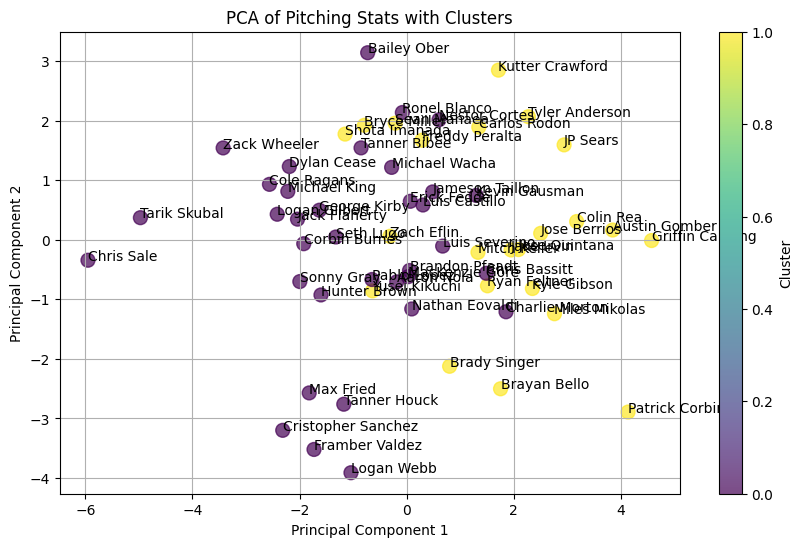

In [101]:
df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df['Cluster'] = pitching['Cluster']

names = [name for name in pitching['Name']]


print("PCA results with clusters:")
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.title('PCA of Pitching Stats with Clusters')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)

for i, txt in enumerate(names):
    ax.annotate(txt, (df['PC1'][i], df['PC2'][i]))

plt.show()


